# TF-Slim Walkthrough

This notebook will walk you through the basics of using TF-Slim to define, train and evaluate neural networks on various tasks. It assumes a basic knowledge of neural networks. 

## Table of contents

<a href="#Install">Installation and setup</a><br>
<a href='#MLP'>Creating your first neural network with TF-Slim</a><br>
<a href='#ReadingTFSlimDatasets'>Reading Data with TF-Slim</a><br>
<a href='#CNN'>Training a convolutional neural network (CNN)</a><br>
<a href='#Pretained'>Using pre-trained models</a><br>


## Installation and setup
<a id='Install'></a>

Since the stable release of TF 1.0, the latest version of slim has been available as `tf.contrib.slim`.
To test that your installation is working, execute the following command; it should run without raising any errors.

```
python -c "import tensorflow.contrib.slim as slim; eval = slim.evaluation.evaluate_once"
```

Although, to use TF-Slim for image classification (as we do in this notebook), you also have to install the TF-Slim image models library from [here](https://github.com/tensorflow/models/tree/master/research/slim). Let's suppose you install this into a directory called TF_MODELS. Then you should change directory to  TF_MODELS/research/slim **before** running this notebook, so that these files are in your python path.

To check you've got these two steps to work, just execute the cell below. If it complains about unknown modules, restart the notebook after moving to the TF-Slim models directory.


In [9]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import tensorflow as tf
import time

from datasets import dataset_utils

# Main slim library
from tensorflow.contrib import slim

## Creating your first neural network with TF-Slim
<a id='MLP'></a>

Below we give some code to create a simple multilayer perceptron (MLP)  which can be used
for regression problems. The model has 2 hidden layers.
The output is a single node. 
When this function is called, it will create various nodes, and silently add them to whichever global TF graph is currently in scope. When a node which corresponds to a layer with adjustable parameters (eg., a fully connected layer) is created, additional parameter variable nodes are silently created, and added to the graph. (We will discuss how to train the parameters later.)

We use variable scope to put all the nodes under a common name,
so that the graph has some hierarchical structure.
This is useful when we want to visualize the TF graph in tensorboard, or if we want to query related
variables. 
The fully connected layers all use the same L2 weight decay and ReLu activations, as specified by **arg_scope**. (However, the final layer overrides these defaults, and uses an identity activation function.)

We also illustrate how to add a dropout layer after the first fully connected layer (FC1). Note that at test time, 
we do not drop out nodes, but instead use the average activations; hence we need to know whether the model is being
constructed for training or testing, since the computational graph will be different in the two cases
(although the variables, storing the model parameters, will be shared, since they have the same name/scope).

In [10]:
def regression_model(inputs, is_training=True, scope="deep_regression"):
    """Creates the regression model.

    Args:
        inputs: A node that yields a `Tensor` of size [batch_size, dimensions].
        is_training: Whether or not we're currently training the model.
        scope: An optional variable_op scope for the model.

    Returns:
        predictions: 1-D `Tensor` of shape [batch_size] of responses.
        end_points: A dict of end points representing the hidden layers.
    """
    with tf.variable_scope(scope, 'deep_regression', [inputs]):
        end_points = {}
        # Set the default weight _regularizer and acvitation for each fully_connected layer.
        with slim.arg_scope([slim.fully_connected],
                            activation_fn=tf.nn.relu,
                            weights_regularizer=slim.l2_regularizer(0.01)):

            # Creates a fully connected layer from the inputs with 32 hidden units.
            net = slim.fully_connected(inputs, 32, scope='fc1')
            end_points['fc1'] = net

            # Adds a dropout layer to prevent over-fitting.
            net = slim.dropout(net, 0.8, is_training=is_training)

            # Adds another fully connected layer with 16 hidden units.
            net = slim.fully_connected(net, 16, scope='fc2')
            end_points['fc2'] = net

            # Creates a fully-connected layer with a single hidden unit. Note that the
            # layer is made linear by setting activation_fn=None.
            predictions = slim.fully_connected(net, 1, activation_fn=None, scope='prediction')
            end_points['out'] = predictions

            return predictions, end_points

### Let's create the model and examine its structure.

We create a TF graph and call regression_model(), which adds nodes (tensors) to the graph. We then examine their shape, and print the names of all the model variables which have been implicitly created inside of each layer. We see that the names of the variables follow the scopes that we specified.

In [11]:
with tf.Graph().as_default():
    # Dummy placeholders for arbitrary number of 1d inputs and outputs
    inputs = tf.placeholder(tf.float32, shape=(None, 1))
    outputs = tf.placeholder(tf.float32, shape=(None, 1))

    # Build model
    predictions, end_points = regression_model(inputs)

    # Print name and shape of each tensor.
    print("Layers")
    for k, v in end_points.items():
        print('name = {}, shape = {}'.format(v.name, v.get_shape()))

    # Print name and shape of parameter nodes  (values not yet initialized)
    print("\n")
    print("Parameters")
    for v in slim.get_model_variables():
        print('name = {}, shape = {}'.format(v.name, v.get_shape()))


Layers
name = deep_regression/fc1/Relu:0, shape = (?, 32)
name = deep_regression/fc2/Relu:0, shape = (?, 16)
name = deep_regression/prediction/BiasAdd:0, shape = (?, 1)


Parameters
name = deep_regression/fc1/weights:0, shape = (1, 32)
name = deep_regression/fc1/biases:0, shape = (32,)
name = deep_regression/fc2/weights:0, shape = (32, 16)
name = deep_regression/fc2/biases:0, shape = (16,)
name = deep_regression/prediction/weights:0, shape = (16, 1)
name = deep_regression/prediction/biases:0, shape = (1,)


### Let's create some 1d regression data .

We will train and test the model on some noisy observations of a nonlinear function.


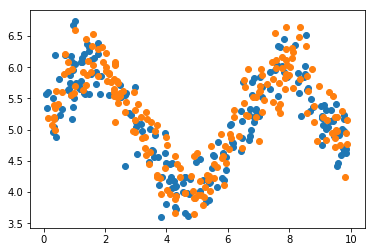

In [12]:
def produce_batch(batch_size, noise=0.3):
    xs = np.random.random(size=[batch_size, 1]) * 10
    ys = np.sin(xs) + 5 + np.random.normal(size=[batch_size, 1], scale=noise)
    return [xs.astype(np.float32), ys.astype(np.float32)]

x_train, y_train = produce_batch(200)
x_test, y_test = produce_batch(200)
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test)

### Let's fit the model to the data

The user has to specify the loss function and the optimizer, and slim does the rest.
In particular,  the slim.learning.train function does the following:

- For each iteration, evaluate the train_op, which updates the parameters using the optimizer applied to the current minibatch. Also, update the global_step.
- Occasionally store the model checkpoint in the specified directory. This is useful in case your machine crashes  - then you can simply restart from the specified checkpoint.

In [13]:
def convert_data_to_tensors(x, y):
    inputs = tf.constant(x)
    inputs.set_shape([None, 1])
    
    outputs = tf.constant(y)
    outputs.set_shape([None, 1])
    return inputs, outputs

In [15]:
# The following snippet trains the regression model using a mean_squared_error loss.
ckpt_dir = '/tmp/regression_model/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    inputs, targets = convert_data_to_tensors(x_train, y_train)

    # Make the model.
    predictions, nodes = regression_model(inputs, is_training=True)

    # Add the loss function to the graph.
    loss = tf.losses.mean_squared_error(labels=targets, predictions=predictions)
    
    # The total loss is the user's loss plus any regularization losses.
    total_loss = slim.losses.get_total_loss()

    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.005)
    train_op = slim.learning.create_train_op(total_loss, optimizer) 

    # Run the training inside a session.
    final_loss = slim.learning.train(
        train_op,
        logdir=ckpt_dir,
        number_of_steps=5000,
        save_summaries_secs=5,
        log_every_n_steps=500)
  
print("Finished training. Last batch loss:", final_loss)
print("Checkpoint saved in %s" % ckpt_dir)

Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 500: loss = 0.4255 (0.00 sec/step)
INFO:tensorflow:global step 1000: loss = 0.2877 (0.00 sec/step)
INFO:tensorflow:global step 1500: loss = 0.2863 (0.00 sec/step)
INFO:tensorflow:global step 2000: loss = 0.2421 (0.00 sec/step)
INFO:tensorflow:global_step/sec: 488.964
INFO:tensorflow:global step 2500: loss = 0.2251 (0.00 sec/step)
INFO:tensorflow:global step 3000: loss = 0.2220 (0.00 sec/step)
INFO:tensorflow:global step 3500: loss = 0.2233 (0.00 sec/step)
INFO:tensorflow:global step 4000: loss = 0.1984 (0.00 sec/step)
INFO:tensorflow:global step 4500: loss = 0.2068 (0.00 sec/step)
INFO:tensorflow:global step 5000: loss = 0.1923 (0.00 sec/step)
INFO:tensorflow:

### Training with multiple loss functions.

Sometimes we have multiple objectives we want to simultaneously optimize.
In slim, it is easy to add more losses, as we show below. (We do not optimize the total loss in this example,
but we show how to compute it.)

In [16]:
with tf.Graph().as_default():
    inputs, targets = convert_data_to_tensors(x_train, y_train)
    predictions, end_points = regression_model(inputs, is_training=True)

    # Add multiple loss nodes.
    mean_squared_error_loss = tf.losses.mean_squared_error(labels=targets, predictions=predictions)
    absolute_difference_loss = slim.losses.absolute_difference(predictions, targets)

    # The following two ways to compute the total loss are equivalent
    regularization_loss = tf.add_n(slim.losses.get_regularization_losses())
    total_loss1 = mean_squared_error_loss + absolute_difference_loss + regularization_loss

    # Regularization Loss is included in the total loss by default.
    # This is good for training, but not for testing.
    total_loss2 = slim.losses.get_total_loss(add_regularization_losses=True)
    
    init_op = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init_op) # Will initialize the parameters with random weights.
        
        total_loss1, total_loss2 = sess.run([total_loss1, total_loss2])
        
        print('Total Loss1: %f' % total_loss1)
        print('Total Loss2: %f' % total_loss2)

        print('Regularization Losses:')
        for loss in slim.losses.get_regularization_losses():
            print(loss)

        print('Loss Functions:')
        for loss in slim.losses.get_losses():
            print(loss)

Instructions for updating:
Use tf.losses.absolute_difference instead.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
Total Loss1: 37.516167
Total Loss2: 37.516163
Regularization Losses:
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
Tensor("deep_regression/fc1/kernel/Regularizer/l2_regularizer:0", shape=(), dtype=float32)
Tensor("deep_regression/fc2/kernel/Regularizer/l2_regularizer:0", shape=(), dtype=float32)
Tensor("deep_regression/prediction/kernel/Regularizer/l2_regularizer:0", shape=(), dtype=float32)
Loss Functions:
Instructions for updating:
Use tf.losses.get_losses instead.
Tensor("mean_square

### Let's load the saved model and use it for prediction.

INFO:tensorflow:Restoring parameters from /tmp/regression_model/model.ckpt-5000


Text(0.5,1,'red=true, blue=predicted')

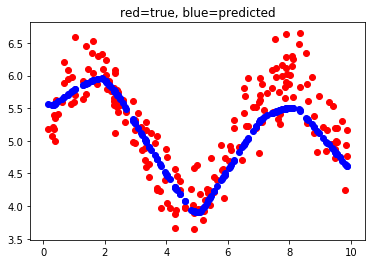

In [17]:
with tf.Graph().as_default():
    inputs, targets = convert_data_to_tensors(x_test, y_test)
  
    # Create the model structure. (Parameters will be loaded below.)
    predictions, end_points = regression_model(inputs, is_training=False)

    # Make a session which restores the old parameters from a checkpoint.
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        inputs, predictions, targets = sess.run([inputs, predictions, targets])

plt.scatter(inputs, targets, c='r');
plt.scatter(inputs, predictions, c='b');
plt.title('red=true, blue=predicted')

### Let's compute various evaluation metrics on the test set.

In TF-Slim termiology, losses are optimized, but metrics (which may not be differentiable, e.g., precision and recall) are just measured. As an illustration, the code below computes mean squared error and mean absolute error metrics on the test set.

Each metric declaration creates several local variables (which must be initialized via tf.initialize_local_variables()) and returns both a value_op and an update_op. When evaluated, the value_op returns the current value of the metric. The update_op loads a new batch of data, runs the model, obtains the predictions and accumulates the metric statistics appropriately before returning the current value of the metric. We store these value nodes and update nodes in 2 dictionaries.

After creating the metric nodes, we can pass them to slim.evaluation.evaluation, which repeatedly evaluates these nodes the specified number of times. (This allows us to compute the evaluation in a streaming fashion across minibatches, which is usefulf for large datasets.) Finally, we print the final value of each metric.


In [20]:
with tf.Graph().as_default():
    inputs, targets = convert_data_to_tensors(x_test, y_test)
    predictions, end_points = regression_model(inputs, is_training=False)

    # Specify metrics to evaluate:
    names_to_value_nodes, names_to_update_nodes = slim.metrics.aggregate_metric_map({
      'Mean Squared Error': slim.metrics.streaming_mean_squared_error(predictions, targets),
      'Mean Absolute Error': slim.metrics.streaming_mean_absolute_error(predictions, targets)
    })

    # Make a session which restores the old graph parameters, and then run eval.
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        print(type(sess))
        print(type(names_to_update_nodes.values))
        print(type(names_to_value_nodes.values))
        print(type(slim.evaluation.evaluation))
        print(dir(slim.evaluation))
        metric_values = slim.evaluation.evaluation(
            sess,
            num_evals=1, # Single pass over data
            eval_op=names_to_update_nodes.values(),
            final_op=names_to_value_nodes.values())

    names_to_values = dict(zip(names_to_value_nodes.keys(), metric_values))
    for key, value in names_to_values.items():
      print('%s: %f' % (key, value))

INFO:tensorflow:Restoring parameters from /tmp/regression_model/model.ckpt
<class 'tensorflow.python.client.session.Session'>
<class 'builtin_function_or_method'>
<class 'builtin_function_or_method'>
<class 'module'>
['_USE_DEFAULT', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'absolute_import', 'checkpoints_iterator', 'division', 'evaluate_once', 'evaluation', 'evaluation_loop', 'monitored_session', 'print_function', 'summary', 'tf_saver', 'wait_for_new_checkpoint']
INFO:tensorflow:Error reported to Coordinator: <class 'TypeError'>, 'module' object is not callable


TypeError: 'module' object is not callable

# Reading Data with TF-Slim
<a id='ReadingTFSlimDatasets'></a>

Reading data with TF-Slim has two main components: A
[Dataset](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/data/dataset.py) and a 
[DatasetDataProvider](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/data/dataset_data_provider.py). The former is a descriptor of a dataset, while the latter performs the actions necessary for actually reading the data. Lets look at each one in detail:


## Dataset
A TF-Slim
[Dataset](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/data/dataset.py)
contains descriptive information about a dataset necessary for reading it, such as the list of data files and how to decode them. It also contains metadata including class labels, the size of the train/test splits and descriptions of the tensors that the dataset provides. For example, some datasets contain images with labels. Others augment this data with bounding box annotations, etc. The Dataset object allows us to write generic code using the same API, regardless of the data content and encoding type.

TF-Slim's Dataset works especially well when the data is stored as a (possibly sharded)
[TFRecords file](https://www.tensorflow.org/versions/r0.10/how_tos/reading_data/index.html#file-formats), where each record contains a [tf.train.Example protocol buffer](https://github.com/tensorflow/tensorflow/blob/r0.10/tensorflow/core/example/example.proto).
TF-Slim uses a consistent convention for naming the keys and values inside each Example record. 

## DatasetDataProvider

A
[DatasetDataProvider](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/data/dataset_data_provider.py) is a class which actually reads the data from a dataset. It is highly configurable to read the data in various ways that may make a big impact on the efficiency of your training process. For example, it can be single or multi-threaded. If your data is sharded across many files, it can read each files serially, or from every file simultaneously.

## Demo: The Flowers Dataset

For convenience, we've include scripts to convert several common image datasets into TFRecord format and have provided
the Dataset descriptor files necessary for reading them. We demonstrate how easy it is to use these dataset via the Flowers dataset below.

### Download the Flowers Dataset
<a id='DownloadFlowers'></a>

We've made available a tarball of the Flowers dataset which has already been converted to TFRecord format.

In [1]:
import tensorflow as tf
from datasets import dataset_utils

url = "http://download.tensorflow.org/data/flowers.tar.gz"
flowers_data_dir = '/tmp/flowers'

if not tf.gfile.Exists(flowers_data_dir):
    tf.gfile.MakeDirs(flowers_data_dir)

dataset_utils.download_and_uncompress_tarball(url, flowers_data_dir) 

>> Downloading flowers.tar.gz 98.4%

### Display some of the data.

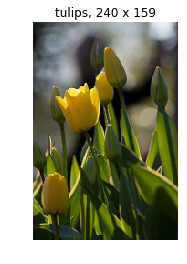

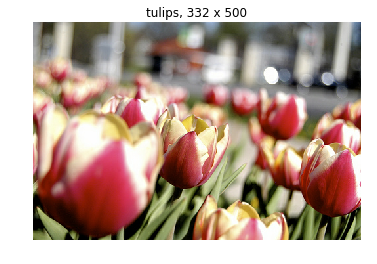

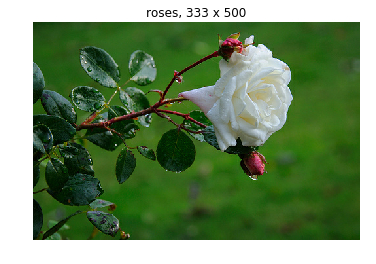

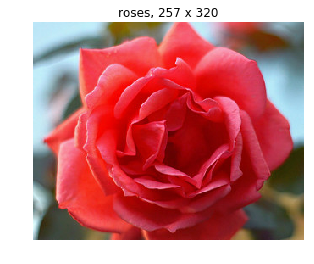

In [25]:
from datasets import flowers
import tensorflow as tf

from tensorflow.contrib import slim

with tf.Graph().as_default(): 
    dataset = flowers.get_split('train', flowers_data_dir)
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=1)
    image, label = data_provider.get(['image', 'label'])
    
    with tf.Session() as sess:    
        with slim.queues.QueueRunners(sess):
            for i in range(4):
                np_image, np_label = sess.run([image, label])
                height, width, _ = np_image.shape
                class_name = name = dataset.labels_to_names[np_label]
                
                plt.figure()
                plt.imshow(np_image)
                plt.title('%s, %d x %d' % (name, height, width))
                plt.axis('off')
                plt.show()

# Convolutional neural nets (CNNs).
<a id='CNN'></a>

In this section, we show how to train an image classifier using a simple CNN.


### Define the model.

Below we define a simple CNN. Note that the output layer is linear function - we will apply softmax transformation externally to the model, either in the loss function (for training), or in the prediction function (during testing).

In [26]:
def my_cnn(images, num_classes, is_training):  # is_training is not used...
    with slim.arg_scope([slim.max_pool2d], kernel_size=[3, 3], stride=2):
        net = slim.conv2d(images, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.conv2d(net, 64, [5, 5])
        net = slim.max_pool2d(net)
        net = slim.flatten(net)
        net = slim.fully_connected(net, 192)
        net = slim.fully_connected(net, num_classes, activation_fn=None)       
        return net

### Apply the model to some randomly generated images.

In [27]:
import tensorflow as tf

with tf.Graph().as_default():
    # The model can handle any input size because the first layer is convolutional.
    # The size of the model is determined when image_node is first passed into the my_cnn function.
    # Once the variables are initialized, the size of all the weight matrices is fixed.
    # Because of the fully connected layers, this means that all subsequent images must have the same
    # input size as the first image.
    batch_size, height, width, channels = 3, 28, 28, 3
    images = tf.random_uniform([batch_size, height, width, channels], maxval=1)
    
    # Create the model.
    num_classes = 10
    logits = my_cnn(images, num_classes, is_training=True)
    probabilities = tf.nn.softmax(logits)
  
    # Initialize all the variables (including parameters) randomly.
    init_op = tf.global_variables_initializer()
  
    with tf.Session() as sess:
        # Run the init_op, evaluate the model outputs and print the results:
        sess.run(init_op)
        probabilities = sess.run(probabilities)
        
print('Probabilities Shape:')
print(probabilities.shape)  # batch_size x num_classes 

print('\nProbabilities:')
print(probabilities)

print('\nSumming across all classes (Should equal 1):')
print(np.sum(probabilities, 1)) # Each row sums to 1

Probabilities Shape:
(3, 10)

Probabilities:
[[ 0.07129037  0.12277782  0.10557041  0.11716354  0.09323899  0.11264404
   0.09842823  0.07884499  0.10865998  0.09138156]
 [ 0.07583151  0.11536857  0.10234261  0.1189041   0.08629532  0.11616556
   0.10178015  0.08709989  0.10065031  0.09556199]
 [ 0.07357361  0.1132975   0.10614088  0.12097182  0.09375949  0.10868114
   0.10027618  0.08232135  0.11317017  0.08780777]]

Summing across all classes (Should equal 1):
[ 0.99999988  1.          0.99999988]


### Train the model on the Flowers dataset.

Before starting, make sure you've run the code to <a href="#DownloadFlowers">Download the Flowers</a> dataset. Now, we'll get a sense of what it looks like to use TF-Slim's training functions found in
[learning.py](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/slim/python/slim/learning.py). First, we'll create a function, `load_batch`, that loads batches of dataset from a dataset. Next, we'll train a model for a single step (just to demonstrate the API), and evaluate the results.

In [28]:
from preprocessing import inception_preprocessing
import tensorflow as tf

from tensorflow.contrib import slim


def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

In [36]:
from datasets import flowers

# This might take a few minutes.
train_dir = '/tmp/tfslim_model/'
print('Will save model to %s' % train_dir)

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)

    dataset = flowers.get_split('train', flowers_data_dir)
    images, _, labels = load_batch(dataset)
  
    # Create the model:
    logits = my_cnn(images, num_classes=dataset.num_classes, is_training=True)
    print(logits)
 
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)

    # Run the training:
    final_loss = slim.learning.train(
      train_op,
      logdir=train_dir,
      number_of_steps=1, # For speed, we just do 1 epoch
      save_summaries_secs=1)
  
    print('Finished training. Final batch loss %d' % final_loss)

Will save model to /tmp/tfslim_model/
Tensor("fully_connected_1/BiasAdd:0", shape=(32, 5), dtype=float32)
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
INFO:tensorflow:Restoring parameters from /tmp/tfslim_model/model.ckpt-1
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global step 2: loss = 4731.1309 (79.08 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.
Finished training. Final ba

### Evaluate some metrics.

As we discussed above, we can compute various metrics besides the loss.
Below we show how to compute prediction accuracy of the trained model, as well as top-5 classification accuracy. (The difference between evaluation and evaluation_loop is that the latter writes the results to a log directory, so they can be viewed in tensorboard.)

In [30]:
from datasets import flowers

# This might take a few minutes.
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.DEBUG)
    
    dataset = flowers.get_split('train', flowers_data_dir)
    images, _, labels = load_batch(dataset)
    
    logits = my_cnn(images, num_classes=dataset.num_classes, is_training=False)
    predictions = tf.argmax(logits, 1)
    
    # Define the metrics:
    names_to_values, names_to_updates = slim.metrics.aggregate_metric_map({
        'eval/Accuracy': slim.metrics.streaming_accuracy(predictions, labels),
        'eval/Recall@5': slim.metrics.streaming_recall_at_k(logits, labels, 5),
    })

    print('Running evaluation Loop...')
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    metric_values = slim.evaluation.evaluate_once(
        master='',
        checkpoint_path=checkpoint_path,
        logdir=train_dir,
        eval_op=names_to_updates.values(),
        final_op=names_to_values.values())

    names_to_values = dict(zip(names_to_values.keys(), metric_values))
    for name in names_to_values:
        print('%s: %f' % (name, names_to_values[name]))


Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].
Running evaluation Loop...
INFO:tensorflow:Starting evaluation at 2018-08-08-14:34:29
INFO:tensorflow:Restoring parameters from /tmp/tfslim_model/model.ckpt-1


TypeError: Fetch argument dict_values([<tf.Tensor 'accuracy/update_op:0' shape=() dtype=float32>, <tf.Tensor 'recall_at_5/update_op:0' shape=() dtype=float32>]) has invalid type <class 'dict_values'>, must be a string or Tensor. (Can not convert a dict_values into a Tensor or Operation.)

# Using pre-trained models
<a id='Pretrained'></a>

Neural nets work best when they have many parameters, making them very flexible function approximators.
However, this  means they must be trained on big datasets. Since this process is slow, we provide various pre-trained models - see the list [here](https://github.com/tensorflow/models/tree/master/research/slim#pre-trained-models).


You can either use these models as-is, or you can perform "surgery" on them, to modify them for some other task. For example, it is common to "chop off" the final pre-softmax layer, and replace it with a new set of weights corresponding to some new set of labels. You can then quickly fine tune the new model on a small new dataset. We illustrate this below, using inception-v1 as the base model. While models like Inception V3 are more powerful, Inception V1 is used for speed purposes.

Take into account that VGG and ResNet final layers have only 1000 outputs rather than 1001. The ImageNet dataset provied has an empty background class which can be used to fine-tune the model to other tasks. VGG and ResNet models provided here don't use that class. We provide two examples of using pretrained models: Inception V1 and VGG-19 models to highlight this difference.


### Download the Inception V1 checkpoint




In [31]:
from datasets import dataset_utils

url = "http://download.tensorflow.org/models/inception_v1_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading inception_v1_2016_08_28.tar.gz 100.0%
Successfully downloaded inception_v1_2016_08_28.tar.gz 24642554 bytes.



### Apply Pre-trained Inception V1 model to Images.

We have to convert each image to the size expected by the model checkpoint.
There is no easy way to determine this size from the checkpoint itself.
So we use a preprocessor to enforce this.

INFO:tensorflow:Restoring parameters from /tmp/checkpoints/inception_v1.ckpt


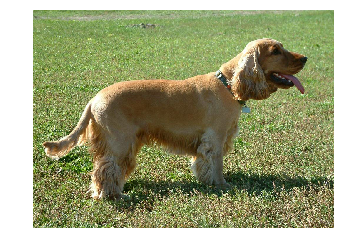

Probability 45.14% => [cocker spaniel, English cocker spaniel, cocker]
Probability 21.55% => [Sussex spaniel]
Probability 10.37% => [Irish setter, red setter]
Probability 5.06% => [Welsh springer spaniel]
Probability 2.99% => [clumber, clumber spaniel]


In [32]:
import numpy as np
import os
import tensorflow as tf

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

from datasets import imagenet
from nets import inception
from preprocessing import inception_preprocessing

from tensorflow.contrib import slim

image_size = inception.inception_v1.default_image_size

with tf.Graph().as_default():
    url = 'https://upload.wikimedia.org/wikipedia/commons/7/70/EnglishCockerSpaniel_simon.jpg'
    image_string = urllib.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(processed_images, num_classes=1001, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
        slim.get_model_variables('InceptionV1'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index]))

### Download the VGG-16 checkpoint

In [33]:
from datasets import dataset_utils
import tensorflow as tf

url = "http://download.tensorflow.org/models/vgg_16_2016_08_28.tar.gz"
checkpoints_dir = '/tmp/checkpoints'

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading vgg_16_2016_08_28.tar.gz 100.0%
Successfully downloaded vgg_16_2016_08_28.tar.gz 513324920 bytes.



### Apply Pre-trained VGG-16 model to Images.

We have to convert each image to the size expected by the model checkpoint.
There is no easy way to determine this size from the checkpoint itself.
So we use a preprocessor to enforce this. Pay attention to the difference caused by 1000 classes instead of 1001.

In [ ]:
import numpy as np
import os
import tensorflow as tf

try:
    import urllib2
except ImportError:
    import urllib.request as urllib

from datasets import imagenet
from nets import vgg
from preprocessing import vgg_preprocessing

from tensorflow.contrib import slim

image_size = vgg.vgg_16.default_image_size

with tf.Graph().as_default():
    url = 'https://upload.wikimedia.org/wikipedia/commons/d/d9/First_Student_IC_school_bus_202076.jpg'
    image_string = urllib.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    processed_image = vgg_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(vgg.vgg_arg_scope()):
        # 1000 classes instead of 1001.
        logits, _ = vgg.vgg_16(processed_images, num_classes=1000, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()
    
    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        # Shift the index of a class name by one. 
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index+1]))

### Fine-tune the model on a different set of labels.

We will fine tune the inception model on the Flowers dataset.

In [34]:
# Note that this may take several minutes.

import os

from datasets import flowers
from nets import inception
from preprocessing import inception_preprocessing

from tensorflow.contrib import slim
image_size = inception.inception_v1.default_image_size


def get_init_fn():
    """Returns a function run by the chief worker to warm-start the training."""
    checkpoint_exclude_scopes=["InceptionV1/Logits", "InceptionV1/AuxLogits"]
    
    exclusions = [scope.strip() for scope in checkpoint_exclude_scopes]

    variables_to_restore = []
    for var in slim.get_model_variables():
        for exclusion in exclusions:
            if var.op.name.startswith(exclusion):
                break
        else:
            variables_to_restore.append(var)

    return slim.assign_from_checkpoint_fn(
      os.path.join(checkpoints_dir, 'inception_v1.ckpt'),
      variables_to_restore)


train_dir = '/tmp/inception_finetuned/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = flowers.get_split('train', flowers_data_dir)
    images, _, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)
        
    # Specify the loss function:
    one_hot_labels = slim.one_hot_encoding(labels, dataset.num_classes)
    slim.losses.softmax_cross_entropy(logits, one_hot_labels)
    total_loss = slim.losses.get_total_loss()

    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total Loss', total_loss)
  
    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = slim.learning.create_train_op(total_loss, optimizer)
    
    # Run the training:
    final_loss = slim.learning.train(
        train_op,
        logdir=train_dir,
        init_fn=get_init_fn(),
        number_of_steps=2)
        
  
print('Finished training. Last batch loss %f' % final_loss)

Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
Instructions for updating:
Use tf.losses.get_total_loss instead.
Instructions for updating:
Use tf.losses.get_losses instead.
Instructions for updating:
Use tf.losses.get_regularization_losses instead.
INFO:tensorflow:Summary name losses/Total Loss is illegal; using losses/Total_Loss instead.
INFO:tensorflow:Restoring parameters from /tmp/checkpoints/inception_v1.ckpt
INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global step 1: loss = 2.1428 (29.64 sec/step)
INFO:tensorflow:global step 2: loss = 3.3466 (18.75 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.
Finished training. Last batch loss 3.346581


### Apply fine tuned model to some images.

Instructions for updating:
Use `tf.local_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /tmp/inception_finetuned/model.ckpt-2


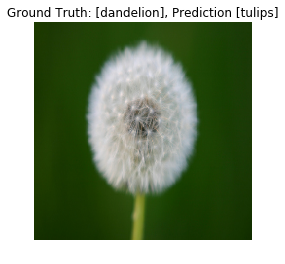

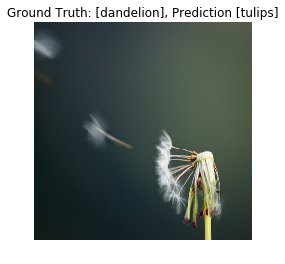

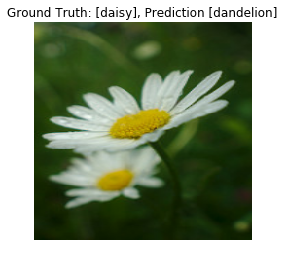

In [35]:
import numpy as np
import tensorflow as tf
from datasets import flowers
from nets import inception

from tensorflow.contrib import slim

image_size = inception.inception_v1.default_image_size
batch_size = 3

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = flowers.get_split('train', flowers_data_dir)
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v1_arg_scope()):
        logits, _ = inception.inception_v1(images, num_classes=dataset.num_classes, is_training=True)

    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()